# Pikes Peak Split Prediction

Many runners set a goal time for themselves in races and will try to keep certain "splits" in order to ensure that they will make it across the finish line within the target. For example, someone trying to run a 3 hour marathon will want to reach the 13 mile point around 90 minutes. This becomes a unique challenge for the Pikes Peak Marathon in Manitou Springs, Colorado because the terrain on the course (consisting of 7800 ft. of elevation gain) and high elevation make it unlike any other race of that distance. This forces us to rely on empirical data to know when to reach the various aid stations in order to summit by a specific time.

The organizers of the race kindly provide the data from each edition in csv format, so here we are working with the results of the 2022 marathon. Note that initially these times are all strings, and in order to perform a regression we must convert them to floats.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime as dt

#getting the data
time_table = pd.read_csv('Pikes Peak Marathon Results September 18, 2022.csv')
time_table = time_table.drop('Unnamed: 0', axis = 1)
time_table.columns = ["OA#","SEX#","AG#","Bib","Age","Sex","AG","Name",
                       "First","Middle","Last","City","ST","Country",
                       "Ws","NoName","Barr Camp","A-Frame","Summit",
                       "A-Frame down","Barr Camp down","NoName down","Ws down",
                       "Ascent","Descent","Finish","Gun","Pace"]
#getting a list of columns with time
time_cols = ["Ws","NoName","Barr Camp","A-Frame","Summit",
            "A-Frame down","Barr Camp down","NoName down","Ws down",
            "Ascent","Descent","Finish"]
#converting these columns to float
time_table[time_cols] = time_table[time_cols].apply(pd.to_timedelta)
time_table[time_cols] = time_table[time_cols].apply(lambda x: x.dt.total_seconds() / 60.0)
#np array of all the summit times, will be used later
summit_arr = time_table['Summit'].to_numpy()

With these data, we can write functions that will plot summit time vs. aid station time for any of the stations that had chip timing (Top of Ws, No Name Creek, Barr Camp, and A-Frame).

In [3]:
#getting the aid station and summit times for a station
def station_times(station_name):
    station_table = time_table[[station_name, 'Summit']]
    station_table = station_table.dropna().reset_index(drop='True')
    return station_table

def station_regression(station_name):
    #getting the data ready
    station_table = station_times(station_name)
    station_arr = station_table[station_name].to_numpy()
    station_arr = np.reshape(station_arr, (-1,1))
    summit_arr = station_table['Summit'].to_numpy()
    #running the regression
    model = linear_model.LinearRegression()
    model.fit(station_arr, summit_arr)
    summit_pred = model.predict(station_arr)
    return summit_pred

And now actually plotting this for Top of Ws, where the blue scatter plot represents actual runner times while the red line is a linear regression made using scikit-learn.

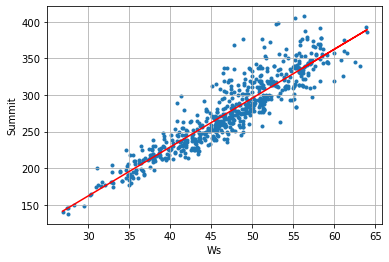

In [5]:
ws_table = station_times('Ws')
ws_reg = station_regression('Ws')
ws_arr = ws_table['Ws'].to_numpy()
ws_summit = ws_table['Summit'].to_numpy()

plt.xlabel('Ws')
plt.ylabel('Summit')
plt.grid()
plt.scatter(ws_arr, ws_summit, marker='.')
plt.plot(ws_arr, ws_reg, color='red')

Similarly, we can estimate the times someone should reach a certain aid station by using a similar regression (with the summit time becoming the independent variable and aid station time becoming dependent). First, we need to set a target summit time in minutes.

In [6]:
summit_goal = 240

Now with that, we can put together a function for the regression that outputs the time one needs to reach the aid station around in order to succeed in their goal. 

In [7]:
def station_prediction(station_name, summit_time):
    #getting the data ready
    station_table = station_times(station_name)
    station_arr = station_table[station_name].to_numpy()
    summit_arr = station_table['Summit'].to_numpy()
    summit_arr = np.reshape(summit_arr, (-1,1))
    #running the regression
    model = linear_model.LinearRegression()
    model.fit(summit_arr, station_arr)
    station_pred = model.predict([[summit_time]])
    return station_pred[0]

This can be utilized on all of the aforementioned timed aid stations (Top of Ws, No Name Creek, Barr Camp, A-Frame).

In [10]:
ws_goal = station_prediction('Ws', summit_goal)
noname_goal = station_prediction('NoName', summit_goal)
barr_goal = station_prediction('Barr Camp', summit_goal)
aframe_goal = station_prediction('A-Frame', summit_goal)

print('Estimated aid station target times (minutes):')
print('Top of Ws: %.2f'% ws_goal)
print('No Name Creek: %.2f'% noname_goal)
print('Barr Camp: %.2f'% barr_goal)
print('A-Frame: %.2f'% aframe_goal)

Estimated aid station target times (minutes):
Top of Ws: 42.52
No Name Creek: 62.64
Barr Camp: 110.62
A-Frame: 162.76


It should be noted that these data are based on the 2022 marathon results, they may vary from year to year and between the marathon and ascent.